In [75]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [73]:
df = pd.read_csv("../data/ff5_factors.csv")
RF = np.nanmean(df["rf"])
df["date"] = pd.to_datetime(df["date"])
df

,date,mktrf,smb,hml,rmw,cma,rf,umd
0,2010-01-04,0.0169,0.0079,0.0113,-0.0017,0.0021,0.00000,0.0059
1,2010-01-05,0.0031,-0.0041,0.0124,-0.0019,0.0019,0.00000,0.0064
2,2010-01-06,0.0013,-0.0013,0.0057,-0.0005,0.0020,0.00000,-0.0004
3,2010-01-07,0.0040,0.0025,0.0098,-0.0069,0.0022,0.00000,-0.0085
4,2010-01-08,0.0033,0.0032,0.0001,0.0022,-0.0037,0.00000,0.0020
...,...,...,...,...,...,...,...,...
3558,2024-02-23,0.0002,0.0032,-0.0003,0.0009,-0.0011,0.00021,0.0000
3559,2024-02-26,-0.0026,0.0097,-0.0011,-0.0074,-0.0001,0.00021,0.0107
3560,2024-02-27,0.0027,0.0124,-0.0045,-0.0114,0.0067,0.00021,-0.0057
3561,2024-02-28,-0.0026,-0.0090,0.0000,-0.0005,0.0053,0.00021,-0.0008


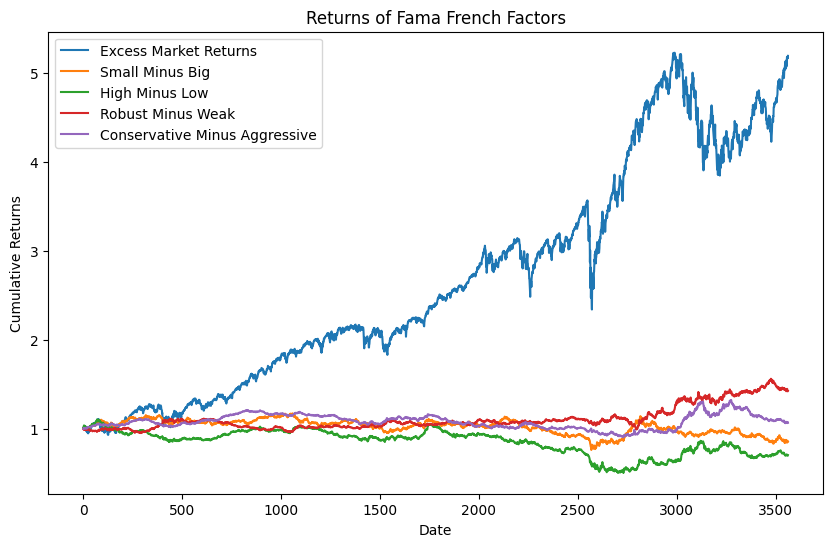

In [74]:
plt.figure(figsize=(10, 6))
mp = {"mktrf": "Excess Market Returns", 
           "smb": "Small Minus Big",
            "hml": "High Minus Low",
            "rmw": "Robust Minus Weak",
            "cma": "Conservative Minus Aggressive"}

for factor, label in mp.items(): 
    plt.plot(df.index, np.cumprod(1 + df[factor]), label=label)
    
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Returns of Fama French Factors")
plt.legend()
plt.show()

### Evaluation Metrics

1. Sharpe Ratio
2. Sortino Ratio
3. Max Drawdown

In [68]:
def sharpe_ratio(returns, rf=None, factor="mktrf", annualized=False) -> np.float64:
    """
    Computes the Sharpe Ratio considering risk free rate.
    """
    scale_factor = np.sqrt(252) if annualized else 1
    np_returns = np.array(returns)
    try:
        if rf or factor != "mktrf":
            return scale_factor * ((np.nanmean(np_returns - rf)) / np.nanstd(np_returns))
        else:
            return scale_factor * (np.nanmean(np_returns) / np.nanstd(np_returns))
    except ZeroDivisionError:
        return np.nan

def sortino_ratio(returns, target_returns, rf=None, factor="mktrf", annualized=False) -> np.float64:
    """
    Computes the Sortino Ratio
    """
    scale_factor = np.sqrt(252) if annualized else 1
    np_returns = np.array(returns)
    mask = (np_returns > 0)
    if not target_returns:
        target_returns = 0
    if mask.all():
        return np.nan
    np_returns[mask] = np.nan
    try:
        if rf or factor != "mktrf":
            return scale_factor * (np.nanmean(np_returns - rf) / np.nanstd(np_returns))
        else:
            return scale_factor * (np.nanmean(np_returns) / np.nanstd(np_returns))
    except ZeroDivisionError:
        return np.nan

def max_drawdown(returns) -> np.float64:
    """
    Evaluates the max drawdown over the entire period of returns.
    """
    arr = np.array(returns)
    #  Handle case where returns length is 0 or 1
    if not arr.shape or arr.shape[0] == 0:
        return 0.0
    elif arr.shape[0] == 1:
        return min(0.0, arr[0])

    cumulative_returns = np.nancumsum(arr)

    # index of trough of the maximum difference (peak to trough)
    drawdown_end = np.nanargmax(np.maximum.accumulate(cumulative_returns) - cumulative_returns)

    # No drawdown
    if drawdown_end == 0:
        return 0.0

    # Bug with numpy where argmax from drawdown_end returns corresponding index
    # as if object was not grouped, but then uses 1-n indexes for slicing which
    # causes drawdowns to be reversed in some cases.
    drawdown_end %= cumulative_returns.shape[0]

    # Index of peak (max value up to trough)
    drawdown_start = np.nanargmax(cumulative_returns[:drawdown_end])
    # Edge case for when drawdown starts at beginning of array
    if drawdown_start != 0 or (drawdown_start == 0 and arr[0] >= 0):
        drawdown_start += 1

    # Computes percentage change as decimal value
    change = np.nanprod(arr[drawdown_start:drawdown_end + 1] + 1) - 1
    change *= -1  # Make the change positive
    return change

In [67]:
stats_mp = {}
for factor in mp:
    sharpe = sharpe_ratio(df[factor], RF, factor=factor)
    sortino = sortino_ratio(df[factor], 0, RF, factor=factor)
    drawdown = max_drawdown(df[factor])
    stats_mp[factor] = [sharpe, sortino, drawdown]

stats_df = pd.DataFrame(stats_mp, index=["Sharpe Ratio", "Sortino Ratio", "Max Drawdown"])
stats_df

,mktrf,smb,hml,rmw,cma
Sharpe Ratio,0.043437,-0.009280,-0.013089,0.015982,-0.001996
Sortino Ratio,-0.846762,-1.153959,-0.947793,-1.085760,-0.991842
Max Drawdown,0.343474,0.348949,0.539425,0.147020,0.253483
